<a href="https://colab.research.google.com/github/btekgit/AdaptiveCNN/blob/master/Cas_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras import activations, regularizers, constraints
from keras import initializers
from keras.engine import InputSpec
import numpy as np
#import tensorflow as tf
import tensorflow as tf
tf.reset_default_graph()


def idx_init(shape, dtype='float32'):
    idxs = np.zeros((shape[0], shape[1]),dtype)
    c = 0
    # assumes square filters
    
    wid = np.int(np.sqrt(shape[0]))
    hei =np.int(np.sqrt(shape[0]))
    f = np.float32
    for x in np.arange(wid):  # / (self.incoming_width * 1.0):
        for y in np.arange(hei):  # / (self.incoming_height * 1.0):
            idxs[c, :] = np.array([x/f(wid-1), y/f(hei-1)],dtype)
            c += 1

    return idxs

def cov_init(shape, dtype='float32'):
    
    cov = np.identity(shape[1], dtype)
    # shape [0] must have self.incoming_channels * self.num_filters
    cov = np.repeat(cov[np.newaxis], shape[0], axis=0)
    
    #for t in range(shape[0]):
    #    cov[t] = cov[t]
    return cov

def sigma_init(shape, initsigma, dtype='float32'):
        
   if isinstance(initsigma,float):  #initialize it with the given scalar
       sigma = initsigma*np.ones(shape[0],dtype='float32')
   elif isinstance(initsigma,tuple) and len(initsigma)==2: #linspace in range
       sigma = np.linspace(initsigma[0], initsigma[1], shape[0],dtype=dtype)
   elif isinstance(initsigma,np.ndarray): # set the values directly from array
       sigma = (initsigma).astype(dtype=dtype)
   else:
       print("Default initial sigma value 0.1 will be used")
       sigma = np.float32(0.1)*np.ones(shape[0],dtype=dtype)

   print("Scale initializer:",sigma)
   return sigma.astype(dtype)



class Conv2DAdaptive(Layer):
    def __init__(self, rank, nfilters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 output_padding=None,
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=False,
                 kernel_regularizer=None,
                 gain=1.0,
                 init_sigma=0.1,
                 init_w=initializers.glorot_uniform(),
                 init_bias = initializers.Constant(),
                 trainsigmas=True,
                 trainWeights=True,
                 reg_bias=None,
                 **kwargs):
        super(Conv2DAdaptive, self).__init__(**kwargs)
        #def __init__(self, num_filters, kernel_sigmaze, incoming_channels=1, **kwargs):
        self.rank = rank
        self.nfilters = nfilters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = data_format
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.gain = gain     
        self.initsigma=init_sigma
        self.initW =init_w
        self.trainsigmas = trainsigmas
        self.trainWeights = trainWeights
        self.bias_initializer =init_bias
        self.bias_regularizer = reg_bias
        self.bias_constraint = None
        self.sigma =None
                 
        #self.input_shape = input_shape
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'))
        print(kwargs)
        self.kernel_size = kernel_size
        
        self.num_filters = nfilters
        #self.incoming_channels = incoming_channels
        
        
        self.output_padding = output_padding
        if self.output_padding is not None:
            self.output_padding = conv_utils.normalize_tuple(
                self.output_padding, 2, 'output_padding')
            for stride, out_pad in zip(self.strides, self.output_padding):
                if out_pad >= stride:
                    raise ValueError('Stride ' + str(self.strides) + ' must be '
                                     'greater than output padding ' +str(self.output_padding))
                    
        super(Conv2DAdaptive, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        
        self.input_channels = input_dim
        kernel_shape = self.kernel_size + (input_dim, self.nfilters)
        print("kernel shape:",kernel_shape)

        self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        # Create a trainable weight variable for this layer.
        
        kernel_size = self.kernel_size
        # Idxs Init
        #mu = np.array([kernel_size[0] // 2, kernel_size[1] // 2])
        mu = np.array([0.5, 0.5])


        # Convert Types
        self.mu = mu.astype(dtype='float32')

        # Shared Parameters
        # below works for only two dimensional cov 
        #self.cov = self.add_weight(shape=[input_dim*self.filters,2,2], 
        #                          name="cov", initializer=cov_init, trainable=False)
        
        #from functools import partial

        #sigma_initializer = partial(sigma_init,initsigma=self.initsigma)
        


    
        self.idxs= idx_init(shape=[kernel_size[0]*kernel_size[1],2])
        
        self.W = self.add_weight(shape=[kernel_size[0],kernel_size[1],
                                        self.input_channels,self.nfilters],
                                 name='Weights',initializer=self.initW,
                                 trainable=True,#self.trainWeights,
                                 constraint=None)
        
        self.Sigma = self.add_weight(shape=(self.nfilters,),
                                          name='Sigma',
                                          initializer=initializers.Constant(self.initsigma),
                                          trainable=self.trainsigmas,
                                          constraint= constraints.NonNeg())        
#        self.kernel = self.add_weight(shape=kernel_shape,
#                                      initializer=initializers.,
#                                      name='kernel',trainable=False,
#                                      regularizer=None,
#                                      constraint=None)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.nfilters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        super(Conv2DAdaptive, self).build(input_shape)  # Be sure to call this somewhere!
        

    
    def U(self):
  
        #e1 = (self.idxs - self.mu)
        #print("e1.shape",e1.shape)
        #print("cov scaler shape",self.cov_scaler)
   
        #print(self.cov.shape)
        #print(len(tf.unstack(self.cov,axis=0)))
        #print( tf.linalg.inv(tf.unstack(self.cov,axis=0)[0]))
        # tensorflow does not need scan it does the same op to all covs.
        #cov_inv = self.cov
        #cov_scaled =self.cov_scaler*self.cov
#        cov_scaled = tf.scalar_mul(self.cov_scaler,self.cov)
#        print(self.cov.shape, self.cov_scaler.shape )
#        cov_scaled = K.batch_dot(self.cov_scaler,self.cov, axes=[1,2])
        #cov_inv = tf.linalg.inv(cov_scaled)
        #print("cov_scaled :",cov_scaled.shape)
        #cov_inv = K.map_fn(lambda x: tf.linalg.inv(x), elems=tf.unstack(self.cov,axis=0))
       

        #e2 = K.dot(e1, K.transpose(cov_inv))
        #ex = K.batch_dot(e2, e1, axes=[[1], [1]])
        #result = K.exp(-(1 / 2.0) * ex)

        up= K.sum((self.idxs - self.mu)**2, axis=1)
        #print("up.shape",up.shape)
        up = K.expand_dims(up,axis=1,)
        #print("up.shape",up.shape)
        # clipping scaler in range to prevent div by 0 or negative cov. 
        sigma = K.clip(self.Sigma,0.01,5.0)
        #cov_scaler = self.cov_scaler
        dwn = 2 * ( sigma ** 2)
        #scaler = (np.pi*self.cov_scaler**2) * (self.idxs.shape[0])
        result = K.exp(-up / dwn)
        


        # Transpose is super important.
        #filter: A 4-D `Tensor` with the same type as `value` and shape
        #`[height, width, in_channels,output_channels]`
        # we do not care about input channels

        masks = K.reshape(result,(self.kernel_size[0], 
                                  self.kernel_size[1],
                                  1,self.nfilters))   

         
        #sum normalization each filter has sum 1
        #sums = K.sum(masks**2, axis=(0, 1), keepdims=True)
        #print(sums)
        #gain = K.constant(self.gain, dtype='float32')
        masks /= K.sqrt(K.sum(K.square(masks), axis=(0, 1),keepdims=True))
        #masks /= (K.sum(masks, axis=(0, 1),keepdims=True)*self.input_channels)
        #masks /= K.sum(masks, axis=(0, 1),keepdims=True)
        #masks /= (self.kernel_size[0]*self.kernel_size[1])
        
        #masks *= (gain*np.sqrt(self.kernel_size[0]*self.kernel_size[1]))
        #ums = sums * sums
        #print("sums shape: ", sums.shape)
        
        # Sum normalisation
        
        #masks = masks * (gain/K.sqrt(sums))
        #masks = masks * (gain/sums)
        #print("masks shape", masks.shape)
        #print("masks mask", K.mean(masks))
        return masks



    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
          c_axis= 1
          
        else:
            h_axis, w_axis = 1, 2
            c_axis=3
            
        ##BTEK 
        in_channels =input_shape[c_axis]
        


        ##BTEK 
        print("Calling self.U:")
        kernel = self.U()
        print("kernel shape in output:",kernel.shape)
        if self.input_channels>1:
            kernel = K.repeat_elements(kernel, self.input_channels, axis=2)
            print("kernel reshaped :",kernel.shape)
        print("inputs shape",inputs.shape)
        #print(K.eval(kernel))
        # multiply with weights
        kernel = kernel*self.W
        
        #---------------------------------------------------------------------
        print("Trainable weights", self._trainable_weights)
        outputs = K.conv2d(
                inputs,
                kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        
        print(outputs.shape)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


        
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
        elif self.data_format == 'channels_first':
            space = input_shape[2:]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=self.dilation_rate[i])
            new_space.append(new_dim)
        if self.data_format == 'channels_last':
            return (input_shape[0],) + tuple(new_space) + (self.nfilters,)
        elif self.data_format == 'channels_first':
            return (input_shape[0], self.filters) + tuple(new_space)
        #return tuple(output_shape)





    
    
#test
def test():
    import tensorflow as tf
    #from gausslayer import GaussScaler
    import numpy as np
    
    tf.reset_default_graph()

    from keras.losses import mse
    import keras
    from keras.datasets import mnist,fashion_mnist, cifar10
    from keras.models import Sequential, Model
    from keras.layers import Input, Dense, Dropout, Flatten
    from skimage import filters
    
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    inputimg = x_train[0]/255
    sh = (inputimg.shape[0],inputimg.shape[1],1)
    outputimages = np.zeros(shape=[inputimg.shape[0],inputimg.shape[1],3],dtype='float32')
    outputimages[:,:,0] = filters.gaussian(inputimg,sigma=1)
    outputimages[:,:,1] = filters.sobel_h(inputimg)
    outputimages[:,:,2] = filters.sobel_v(filters.gaussian(inputimg,sigma=0.5))
    
    y = y_train[0]
    
    node_in = Input(shape=sh, name='inputlayer')
    node_acnn = Conv2DAdaptive(rank=2,nfilters=3,kernel_size=(7,7), 
                             data_format='channels_last',
                             padding='same',name='acnn',activation='tanh',
                             init_sigma=0.1, trainsigmas=True, 
                             trainWeights=True)(node_in)
    
    
    
    
    model = Model(inputs=node_in, outputs=[node_acnn])
    model.reset_states()
   # model.summary()

    
    sgd = keras.optimizers.SGD(lr=3.0, decay=0.000,momentum=0.0, nesterov=False)
    model.compile(loss=mse, optimizer=sgd, metrics=['accuracy'])
    model.summary()
    
    
    inputimg2 = np.expand_dims(np.expand_dims(inputimg,axis=0), axis=3)
    outputimages2 = np.expand_dims(outputimages,axis=0)
    
    model.fit(inputimg2, outputimages2,
              batch_size=1,
              epochs=50,
              verbose=1)

    
    acnn_layer = model.get_layer('acnn')    
    all_params=acnn_layer.weights
    print("All params:",all_params)
    acnn_params = acnn_layer.get_weights()
    for i,v in enumerate(all_params):
        print(v, ":", acnn_params[i],"\n")
    #out = acnn_layer.get_output_at(0)
#
#    with tf.Session() as sess:
#        sess.run(tf.global_variables_initializer())
#        outval = sess.run(out, feed_dict={inputs:inputimg2})
#        acnn_layer_var = acnn_layer.get_weights()
    
    
    pred_images = model.predict(inputimg2,  verbose=1)
    print("Prediction shape",pred_images.shape)
    plt = True
    if plt:
        print("Plotting kernels before...")
        import matplotlib.pyplot as plt
        num_images=min(pred_images.shape[3],12)
        fig=plt.figure(figsize=(10,5))
        plt.subplot(3, num_images, 2)
        plt.imshow(np.squeeze(inputimg2[0,:,:,0]))
        for i in range(num_images):
            plt.subplot(3, num_images, i+4)
            plt.imshow(np.squeeze(outputimages2[0,:,:,i]))
            print("Max-in:",i," ",np.max(np.squeeze(outputimages2[0,:,:,i])))
        
        for i in range(num_images):
            plt.subplot(3, num_images, i+7)
            plt.imshow(np.squeeze(pred_images[0,:,:,i]))
            print("MAx:","pred",i,np.max(np.squeeze(pred_images[0,:,:,i])))
        #fig.colorbar(im, ax=ax1)
        plt.show()
        
        
    print( model.get_layer('acnn').output )

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
{'name': 'acnn-1'}
kernel shape: (5, 5, 32, 32)
Calling self.U:
kernel shape in output: (5, 5, 1, 32)
kernel reshaped : (5, 5, 32, 32)
inputs shape (?, 28, 28, 32)
Trainable weights [<tf.Variable 'acnn-1_3/Weights:0' shape=(5, 5, 32, 32) dtype=float32_ref>, <tf.Variable 'acnn-1_3/Sigma:0' shape=(32,) dtype=float32_ref>]
(?, 28, 28, 32)
{'name': 'acnn-2'}
kernel shape: (5, 5, 32, 32)
Calling self.U:
kernel shape in output: (5, 5, 1, 32)
kernel reshaped : (5, 5, 32, 32)
inputs shape (?, 14, 14, 32)
Trainable weights [<tf.Variable 'acnn-2_3/Weights:0' shape=(5, 5, 32, 32) dtype=float32_ref>, <tf.Variable 'acnn-2_3/Sigma:0' shape=(32,) dtype=float32_ref>]
(?, 14, 14, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_____________________________________________________

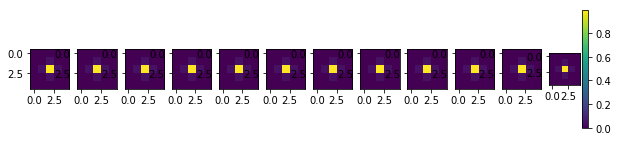

W0622 10:08:20.710179 139984547719040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 18s 305us/step - loss: 0.9462 - acc: 0.7034 - val_loss: 0.3355 - val_acc: 0.9248
Epoch 2/500
60000/60000 [==============================] - 13s 217us/step - loss: 0.3821 - acc: 0.8855 - val_loss: 0.2113 - val_acc: 0.9484
Epoch 3/500
60000/60000 [==============================] - 13s 215us/step - loss: 0.2704 - acc: 0.9199 - val_loss: 0.1721 - val_acc: 0.9556
Epoch 4/500
60000/60000 [==============================] - 13s 214us/step - loss: 0.2210 - acc: 0.9347 - val_loss: 0.1476 - val_acc: 0.9615
Epoch 5/500
60000/60000 [==============================] - 13s 213us/step - loss: 0.1918 - acc: 0.9420 - val_loss: 0.1316 - val_acc: 0.9647
Epoch 6/500
60000/60000 [==============================] - 13s 213us/step - loss: 0.1745 - acc: 0.9475 - val_loss: 0.1233 - val_acc: 0.9672
Epoch 7/500
60000/60000 [==============================] - 13s 214us/step - loss: 0.1568 - acc: 0.9523 - val_l

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 21 17:27:34 2019

@author: btek
"""

import keras
from keras.datasets import mnist,cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization,Activation
from keras.optimizers import SGD
from keras import backend as K


#dset='cifar10'#mnist
dset='mnist'
batch_size = 512
num_classes = 10
epochs = 500

if dset=='mnist':
    # input image dimensions
    img_rows, img_cols = 28, 28  
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    n_channels=1

elif dset=='cifar10':    
    img_rows, img_cols = 32,32
    n_channels=3
    
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_rows, img_cols)
    input_shape = (n_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_channels)
    input_shape = (img_rows, img_cols, n_channels)
        

    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='linear',padding='same',
          input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='linear',padding='same'))
#odel.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))

#odel.add(Dense(128, activation='relu'))

#odel.add(Dropout(0.25))

  #=============================================================================
model.add(Conv2DAdaptive(rank=2,nfilters=32,kernel_size=(5,5), 
                       data_format='channels_last',strides=1,
                       padding='same',name='acnn-1', activation='linear'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

model.add(Conv2DAdaptive(rank=2,nfilters=32,kernel_size=(5,5), 
                       data_format='channels_last',strides=1,
                       padding='same',name='acnn-2', activation='linear'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

  
model.add(Dropout(0.25))


   
#=============================================================================
    

model.add(Dense(num_classes, activation='softmax'))
model.summary()

from lr_multiplier import LearningRateMultiplier

multipliers = {'acnn-1': 1.0,'acnn-2': 1.0}
opt = LearningRateMultiplier(SGD, lr_multipliers=multipliers, 
                             lr=0.01, momentum=0.0,decay=0.00)
print(opt)
#opt = SGD(lr=0.01,momentum=0.5)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

plt = True
if plt:
    print("Plotting kernels before...")
    import matplotlib.pyplot as plt
    acnn_layer = model.get_layer('acnn-1')
    ws = acnn_layer.get_weights()
    print("Sigmas before",ws[0])
    u_func = K.function(inputs=[model.input], outputs=[acnn_layer.U()])
    output_func = K.function(inputs=[model.input], outputs=[acnn_layer.output])

    U_val=u_func([np.expand_dims(x_test[0], axis=0)])
    
    print("U shape", U_val[0].shape)
    print("U max:", np.max(U_val[0][:,:,:,:]))
    num_filt=min(U_val[0].shape[3],12)
    fig=plt.figure(figsize=(10,5))
    for i in range(num_filt):
        ax1=plt.subplot(1, num_filt, i+1)
        im = ax1.imshow(np.squeeze(U_val[0][:,:,0,i]))
    fig.colorbar(im, ax=ax1)
    plt.show()
    

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


if plt:
    print("Plotting kernels after ...")
    
    print("U max:", np.max(U_val[0][:,:,:,:]))
    import matplotlib.pyplot as plt
    ws = acnn_layer.get_weights()
    print("Sigmas after",ws[0])
    U_val=u_func([np.expand_dims(x_test[2], axis=0)])
    
    print("U shape", U_val[0].shape)
    num_filt=min(U_val[0].shape[3],12)
    fig=plt.figure(figsize=(16,5))
    for i in range(num_filt):
        ax=plt.subplot(1, num_filt, i+1)
        im = ax.imshow(np.squeeze(U_val[0][:,:,0,i]))
    #fig.colorbar(im, ax=ax1)
    plt.show()
    
    
    print("outputs  ...")
    
    n=5
    
    out_val=output_func([np.expand_dims(x_test[5], axis=0)])
    print("Outputs shape", out_val[0].shape)
    num_filt=min(out_val[0].shape[3],12)
    fig=plt.figure(figsize=(16,10))
    ax=plt.subplot(1, num_filt+1, 1)
    im = ax.imshow(np.squeeze(x_test[5]))
    print(y_test[5])
    print("input mean,var,max",np.mean(x_test[n]),np.var(x_test[n]),np.max(x_test[n]))
    for i in range(num_filt):
        ax=plt.subplot(1, num_filt+1, i+2)
        out_im = out_val[0][0,:,:,i]
        im = ax.imshow(np.squeeze(out_im))
        print("ouput mean,var,max",np.mean(out_im),
                                       np.var(out_im),
                                       np.max(out_im))
        #plt.colorbar(im,ax=ax)
    plt.show()


In [0]:
test_mnist()